## BIG DATA Project
### Data Analysis of parking meters in the city of Paris

#### Imports

In [33]:
import pymongo
import folium
import json
import matplotlib.pyplot
import pandas
import scipy.stats
import numpy
import seaborn
import html
%matplotlib inline
from pprint import pprint
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN

In [34]:
con = pymongo.MongoClient("mongodb://193.51.82.104:2343/")
horo = con.horodateurs
mob = horo.mobiliers
horo.list_collection_names()

['transactions_small', 'myresults', 'transactions', 'mobiliers']

#### Composition of each element

In [35]:
pprint(horo.myresults.find_one())

{'_id': {'zone': '10E'},
 'value': {'modele': ', , , , , SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, '
                     'SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, '
                     'SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, '
                     'SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SAB3, SMB2, '
                     'SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, '
                     'SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, '
                     'SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, SMB2, , SAB3, SMB2',
           'numHoro': ', , , , , 98380401, 98380701, 20880101, 22070201, '
                      '47980201, 47980302, 51160101, 42930101, 86992701, '
                      '9520201, 13780102, 16860201, 98380101, 42930301, '
                      '42930501, 42930401, 20880404, 20880301, 22070305, '
                      '49640106, 49640302, 86992304, 60760103, 9520102, '
                      '13790402, 13790202, 13790602, 8699

In [36]:
pprint(horo.transactions.find_one())

{'_id': ObjectId('56eaa8279fae0d71f77ea2bd'),
 'date horodateur': datetime.datetime(2014, 1, 9, 14, 9, 47),
 'durée payée (h)': 0.5,
 'début stationnement': datetime.datetime(2014, 1, 9, 14, 9, 47),
 'fin stationnement': datetime.datetime(2014, 1, 9, 14, 39, 47),
 'horodateur': 1050,
 'montant carte': 1.8,
 'moyen de paiement': 'Paris Carte',
 'usager': 'Rotatif'}


In [37]:
pprint(horo.transactions_small.find_one())

{'_id': ObjectId('56eaaa009fae0d71f756f620'),
 'date horodateur': datetime.datetime(2014, 7, 16, 12, 51, 9),
 'durée payée (h)': 1.0,
 'début stationnement': datetime.datetime(2014, 7, 16, 12, 51, 9),
 'fin stationnement': datetime.datetime(2014, 7, 16, 13, 51, 9),
 'horodateur': 36590413,
 'montant': 1.2,
 'moyen de paiement': 'Paris Carte',
 'usager': 'Rotatif'}


In [38]:
pprint(horo.mobiliers.find_one())

{'_id': ObjectId('56eaa4552d7eb34e4432e0fb'),
 'datasetid': 'horodateurs-mobiliers',
 'fields': {'adresse': '48 vis-à-vis RUE DE LISBONNE',
            'alim': 'SOLAIRE',
            'arrondt': 8,
            'geo_point_2d': [48.877489999731374, 2.311394999713242],
            'geo_shape': {'coordinates': [2.311394999713242,
                                          48.877489999731374],
                          'type': 'Point'},
            'modele': 'SAB3',
            'numhoro': 57080603,
            'objectid': 4383,
            'regime': 'MIX',
            'tarif': '4,00 E MIX 2U',
            'tarifhor': 4.0,
            'zoneres': '8J'},
 'geometry': {'coordinates': [2.311394999713242, 48.877489999731374],
              'type': 'Point'},
 'record_timestamp': '2015-12-02T17:49:46+00:00',
 'recordid': '698c75a21ba4f4c34e72f32ea1ecd94f9de8b88c'}


#### Different type of power and their number

In [39]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.alim", "nb" : { "$sum" : 1}}}
]))
df = pandas.DataFrame(res) 
df.columns = ["Alimentation", "Effectif"]
df

,Alimentation,Effectif
0,None,8
1,PILE,2994
2,SOLAIRE,4808


#### Data Paris Arrondissements

In [40]:
geo = json.load(open("../data/paris-arrondissements.geojson"))
geo["features"][0]['geometry']

{'type': 'Polygon',
 'coordinates': [[[2.351518483670821, 48.8644258050741],
   [2.350949105218923, 48.86340592861751],
   [2.346676032763327, 48.864430925901665],
   [2.346675453051013, 48.86443106483368],
   [2.345101655171463, 48.864809197959836],
   [2.341271025930368, 48.86572767724484],
   [2.34126849090564, 48.86572828653819],
   [2.341204510696185, 48.865743681005995],
   [2.341178272058699, 48.86574963323163],
   [2.341083555178273, 48.86577201721946],
   [2.337371969067098, 48.86664907439458],
   [2.335869691238243, 48.86699647535598],
   [2.335869054057415, 48.86699662650754],
   [2.333675321300195, 48.867516125009374],
   [2.33172601351949, 48.867954816599685],
   [2.331725629348361, 48.86795490259037],
   [2.330656733960091, 48.86819218066118],
   [2.330306795320876, 48.86835619167468],
   [2.329965588686572, 48.86851416917429],
   [2.328007329038849, 48.86991742140715],
   [2.32984034160984, 48.87023196300484],
   [2.332082346211126, 48.87061659840104],
   [2.334150445666

#### Map of Paris and its districts

In [41]:
geo = json.load(open("../data/paris-arrondissements.geojson"))

centre = [48.86, 2.35]
carte = folium.Map(location = centre, zoom_start = 12)
carte.choropleth(geo_data = geo)
carte

#### Number of parking meters by district

In [42]:
res = mob.aggregate([
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1}}},
    { "$sort" : { "_id": 1}}
])
df = pandas.DataFrame(list(res)) 
df.columns = ["Arrondissement", "Effectif"]
df

,Arrondissement,Effectif
0,1,87
1,2,67
2,3,133
3,4,135
4,5,267
5,6,174
6,7,361
7,8,376
8,9,227
9,10,197


**Histogram**

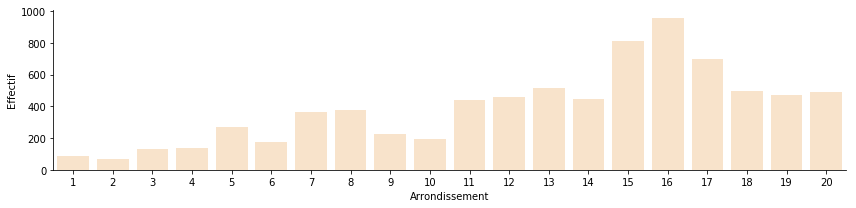

In [43]:
seaborn.catplot(x = "Arrondissement", y = "Effectif", color = "bisque",
                   data = df, kind = "bar", height = 3, aspect = 4)

**Pie Chart**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E869F07B38>],
      dtype=object)

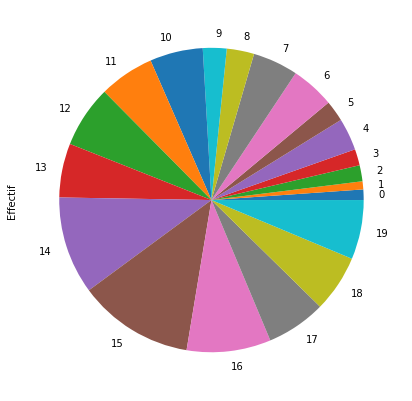

In [44]:
df.Effectif.plot.pie(subplots=True, figsize = (7, 7))

Ici, le 0 correspond au premier arrondissement, donc tous les arrondissements sont décalés de 1.

#### Map showing the number of parking meters by borough

In [45]:
carte2 = folium.Map(location = centre, zoom_start = 12)
carte2.choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df, columns = ["Arrondissement", "Effectif"],
                 fill_color= "YlGn",
                 legend_name = "Nombre de mobiliers par quartier")
carte2

L'histogramme, le camembert, et la carte permettent de remarquer que le plus grand nombre d'horodateurs se trouvent dans le 15e, 16e et 17e arrondissement, ce qui semble logique car ces arrondissements sont les plus grands en termes de superficie.

#### Coordinates of timestamps

In [46]:
res1 = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$geometry"}}
]))


In [47]:
horodat = pandas.DataFrame(list(res1))
horodat.loc[0,"_id"]["coordinates"][::-1]

[48.85722499998231, 2.3934080006304486]

In [48]:
liste = list(
    zip(
        [r["coordinates"][1] for r in horodat["_id"]], 
        [r["coordinates"][0] for r in horodat["_id"]]
    )
)
liste[:10]

[(48.85722499998231, 2.3934080006304486),
 (48.849304999880665, 2.3992490005780893),
 (48.893427469691666, 2.3388402697371427),
 (48.83235099961172, 2.39709500020633),
 (48.85017099996656, 2.399083000387102),
 (48.85530919001924, 2.3953924400879365),
 (48.84090900040269, 2.2628510003447397),
 (48.8574879996397, 2.3928900002946847),
 (48.85265199975123, 2.379772000622882),
 (48.84082200037027, 2.3861400003544646)]

#### Map of all Paris time clocks

In [49]:
carte3 = folium.Map(location = centre, zoom_start = 12)
carte3.choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df, columns = ["Arrondissement", "Effectif"],
                 fill_color= "YlGn",
                 legend_name = "Nombre de mobiliers par quartier")
FastMarkerCluster(liste).add_to(carte3)
carte3

#### Tariffs and Boroughs

In [50]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "tar" : "$fields.tarifhor", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "tarif" : "$_id.tar", "arrondissement" : "$_id.arr", "effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df = pandas.DataFrame(res).drop("_id", 1)
df.head()

,arrondissement,effectif,tarif
0,1,87,4.0
1,2,67,4.0
2,3,133,4.0
3,4,135,4.0
4,5,267,4.0


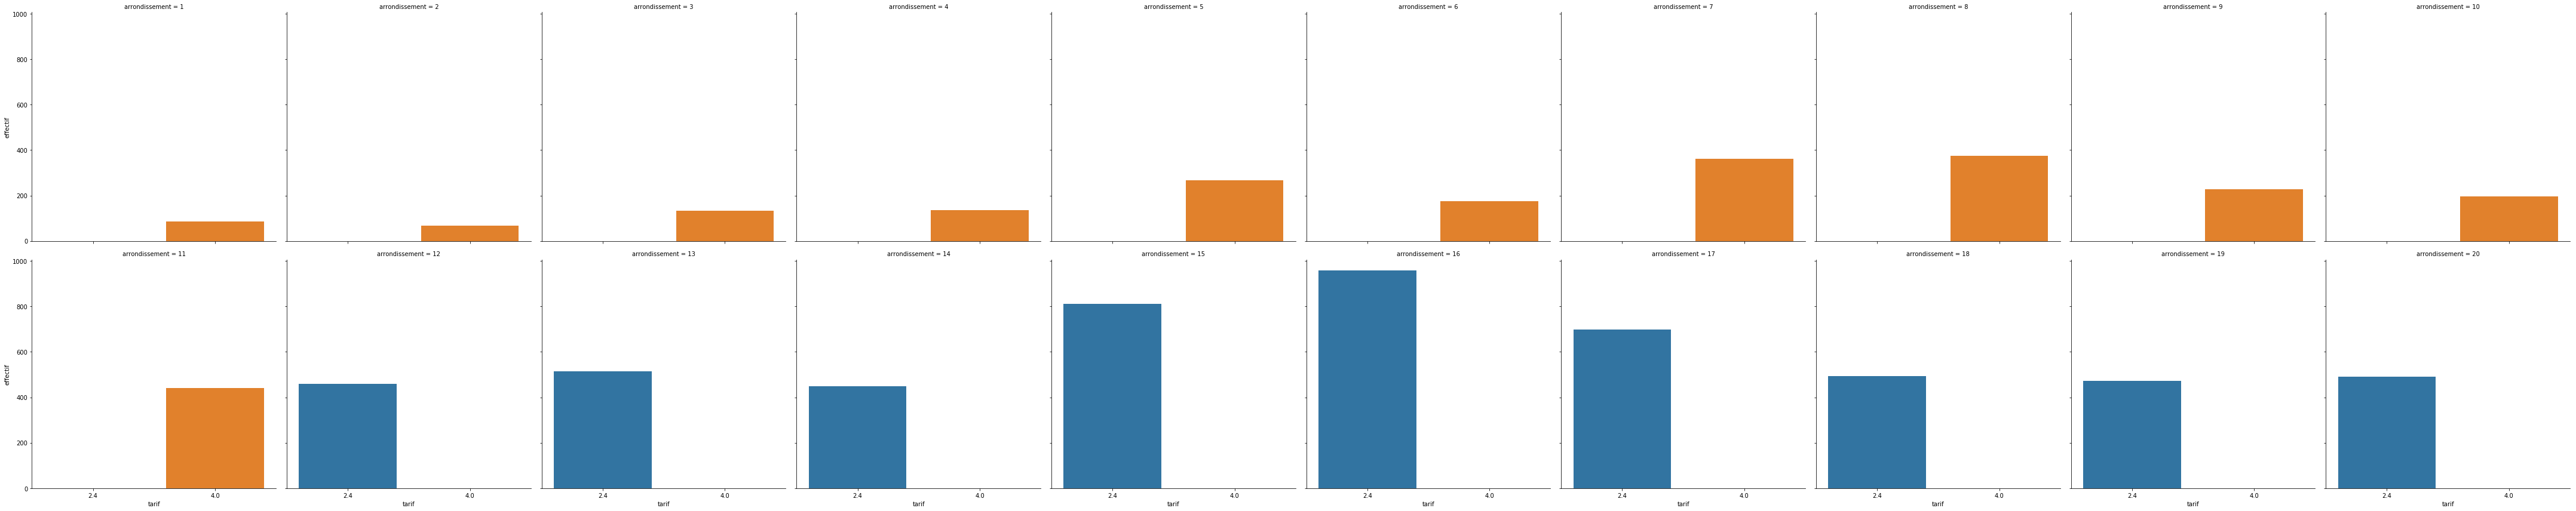

In [51]:
seaborn.catplot(x = "tarif", y = "effectif",
                   col = "arrondissement", col_wrap = 10,
                   data = df, kind = "bar", height = 6)

Selon les arrondissements, les tarifs ne sont pas identiques

#### Rate table by district

In [52]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "tar" : "$fields.tarifhor", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "Tarif" : "$_id.tar", "Arrondissement" : "$_id.arr", "Effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df1 = pandas.DataFrame(res).drop("_id", 1)
df1

,Arrondissement,Effectif,Tarif
0,7,361,4.0
1,6,174,4.0
2,3,133,4.0
3,12,458,2.4
4,10,197,4.0
5,15,810,2.4
6,13,514,2.4
7,1,87,4.0
8,17,698,2.4
9,14,448,2.4


**Price stamps map based on price**

In [53]:
carte4 = folium.Map(location = centre, zoom_start = 12)
carte4.choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df1, columns = ["Arrondissement", "Tarif"],
                 fill_color= "OrRd",
                 legend_name = "Tarif par arrondissement")
FastMarkerCluster(liste).add_to(carte4)
carte4

On remarque que le centre de Paris est plus cher que les zones autours du centre, cela peut s'expliquer par la présence des principaux lieux touristiques dans les zones centre de Paris.

#### Number of time stamps by rounding according to the regime

In [54]:
res2 = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "reg" : "$fields.regime", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "regime" : "$_id.reg", "arrondissement" : "$_id.arr", "effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df2 = pandas.DataFrame(res2).drop("_id", 1)
df2

,arrondissement,effectif,regime
0,1,24,ROT
1,1,63,MIX
2,2,18,ROT
3,2,49,MIX
4,3,82,MIX
5,3,51,ROT
6,4,17,ROT
7,4,118,MIX
8,5,26,ROT
9,5,241,MIX


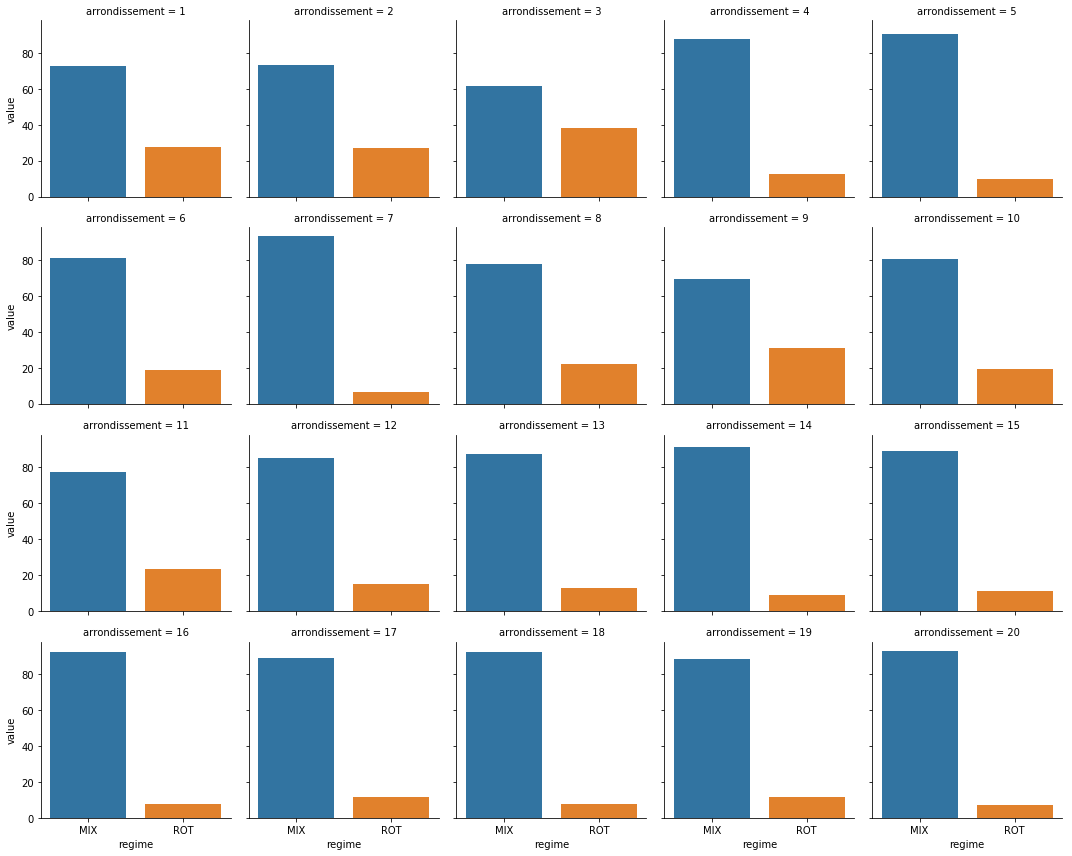

In [55]:
t = pandas.crosstab(df2.regime, df2.arrondissement, df2.effectif, normalize = "columns", aggfunc = sum)
t = t.assign(regime = t.index)
tm = pandas.melt(t, id_vars = "regime")
tm = tm.assign(value = 100 * tm.value)

seaborn.catplot(x = "regime", y = "value", 
                   col = "arrondissement", col_wrap = 5, 
                   data = tm, kind = "bar", height = 3)

In [56]:
res0 = mob.find({ "fields": { "$ne": [] }})

In [57]:
df0 = pandas.DataFrame(list(res0))

#### In the form of a map

In [58]:
carte5 = folium.Map(location = centre, zoom_start = 12)
groupes = MarkerCluster().add_to(carte5)
for i in range(1500): # because for 2000, the card remains empty
    folium.Marker(horodat.loc[i,"_id"]["coordinates"][::-1], popup = html.escape(df0.loc[i,"fields"]["regime"])).add_to(groupes)
carte5

#### Model and staff by district

In [59]:
res3 = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "mod" : "$fields.modele", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "modele" : "$_id.mod", "arrondissement" : "$_id.arr", "effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df3 = pandas.DataFrame(res3).drop("_id", 1)
df3

,arrondissement,effectif,modele
0,1,1,MUI
1,1,86,SAB3
2,2,67,SAB3
3,3,133,SAB3
4,4,135,SAB3
5,5,34,SAB3
6,5,233,SMB2
7,6,57,SMB2
8,6,117,SAB3
9,7,45,SAB3


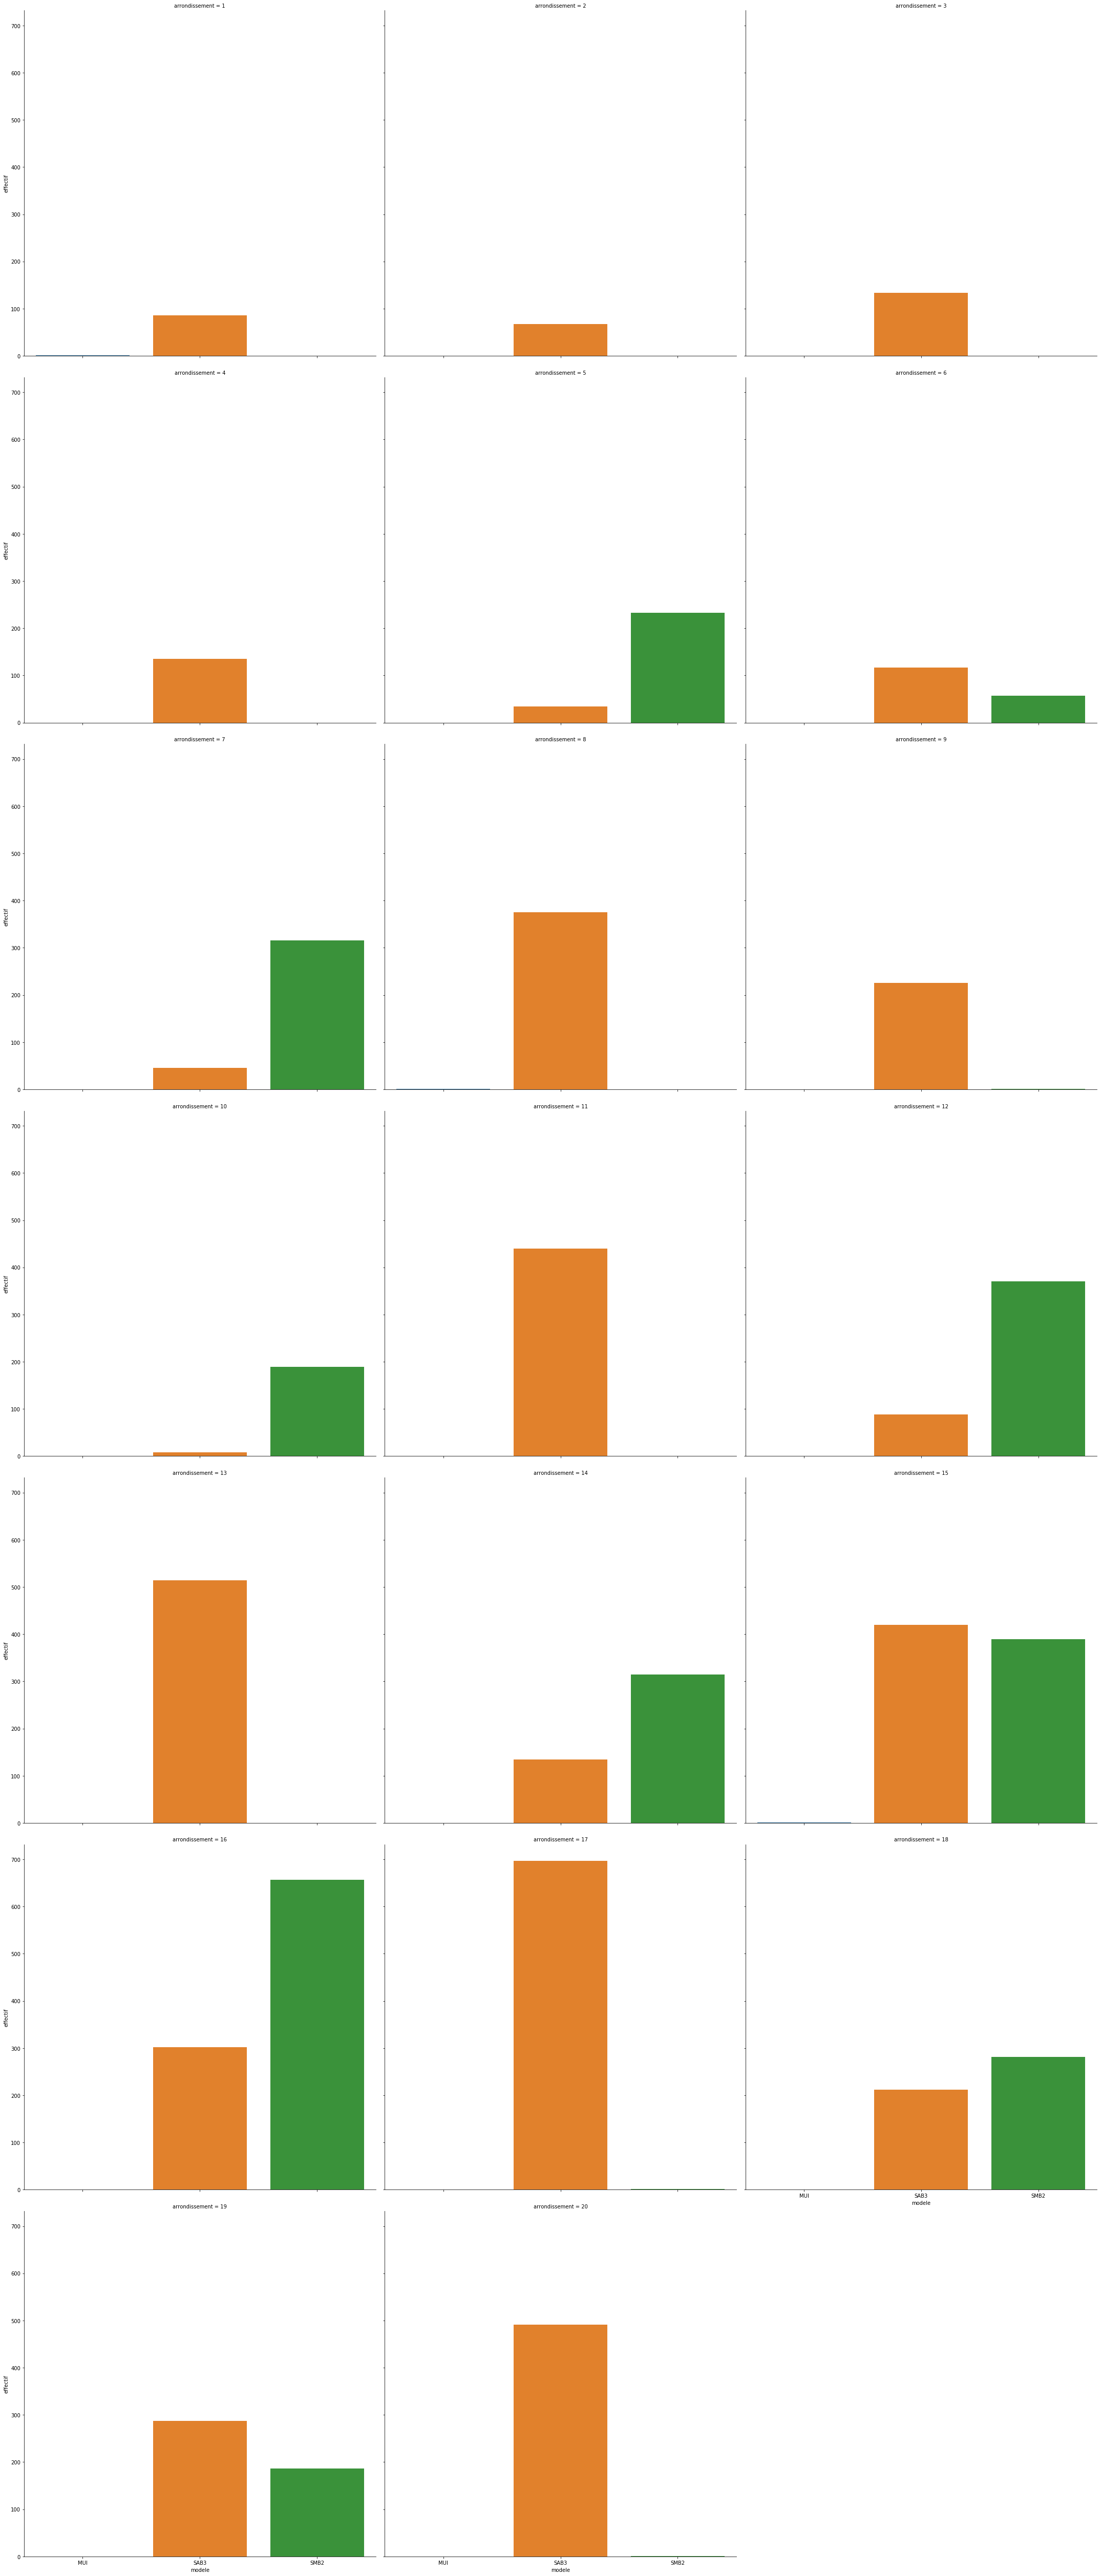

In [60]:
seaborn.catplot(x = "modele", y = "effectif",
                   col = "arrondissement", col_wrap = 3,
                   data = df3, kind = "bar", height = 10)

In [61]:
res4 = list(horo.transactions_small.find({}, {"_id": 0, "montant carte" : 1}))

Montant payés sous forme de carte et des durées

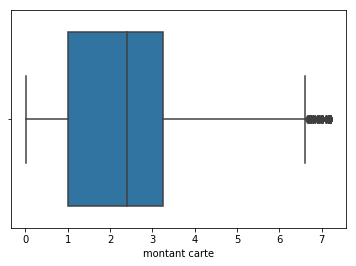

In [62]:
seaborn.boxplot(x = "montant carte", data = df4)


On va lister les différents moyens de paiements et le type des usagers en fonction du nombres de paiements.


In [63]:
res = list(horo.transactions.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
df1=pandas.DataFrame(res)
df1

,_id,nb
0,Paris Carte,13181015
1,CB,11267015


In [64]:
res = list(horo.transactions.aggregate([
    { "$group" : { "_id" : "$usager", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
df2=pandas.DataFrame(res)
df2

,_id,nb
0,Rotatif,19033897
1,Résident,5414133


#### Total and average amount per district

In [65]:
res = list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    {"$unwind": "$transactions"},
    {"$limit": 20000},
    {"$group": {"_id": {"arrondissement": "$fields.arrondt"}, "Recette": {"$sum": "$transactions.montant carte"}, "Moyenne Carte": {"$avg": "$transactions.montant carte"},"Moyenne Durée Payée": {"$avg":"$transactions.durée payée (h)"}}},
    {"$sort": {"_id": 1 }}
]))
pprint(res)

[{'Moyenne Carte': 4.561734693877551,
  'Moyenne Durée Payée': 3.070816326530612,
  'Recette': 447.05,
  '_id': {'arrondissement': 1}},
 {'Moyenne Carte': 4.147916666666666,
  'Moyenne Durée Payée': 5.904583333333333,
  'Recette': 497.75,
  '_id': {'arrondissement': 2}},
 {'Moyenne Carte': 4.427941176470589,
  'Moyenne Durée Payée': 6.0064705882352944,
  'Recette': 301.1,
  '_id': {'arrondissement': 3}},
 {'Moyenne Carte': 3.6736070381231674,
  'Moyenne Durée Payée': 6.770791788856306,
  'Recette': 1252.7,
  '_id': {'arrondissement': 4}},
 {'Moyenne Carte': 3.657514644351465,
  'Moyenne Durée Payée': 8.705271966527196,
  'Recette': 4370.7300000000005,
  '_id': {'arrondissement': 5}},
 {'Moyenne Carte': 3.825993091537133,
  'Moyenne Durée Payée': 7.883436960276339,
  'Recette': 2215.25,
  '_id': {'arrondissement': 6}},
 {'Moyenne Carte': 3.7899906976744187,
  'Moyenne Durée Payée': 9.493497674418604,
  'Recette': 4074.2400000000002,
  '_id': {'arrondissement': 7}},
 {'Moyenne Carte': 3.

In [66]:
df = pandas.DataFrame(res)
df = df.assign(
    Arrondissement = [a['arrondissement'] for a in df._id],
).drop("_id", 1)
df

,Moyenne Carte,Moyenne Durée Payée,Recette,Arrondissement
0,4.561735,3.070816,447.05,1
1,4.147917,5.904583,497.75,2
2,4.427941,6.006471,301.10,3
3,3.673607,6.770792,1252.70,4
4,3.657515,8.705272,4370.73,5
5,3.825993,7.883437,2215.25,6
6,3.789991,9.493498,4074.24,7
7,3.784263,5.683116,5574.22,8
8,3.105355,6.338945,3148.83,9
9,2.835355,7.455694,1837.31,10


In [67]:
df.sort_values(by = 'Recette', ascending = False)

,Moyenne Carte,Moyenne Durée Payée,Recette,Arrondissement
15,2.504662,9.454956,5705.62,16
7,3.784263,5.683116,5574.22,8
16,2.365128,10.192051,4427.52,17
4,3.657515,8.705272,4370.73,5
6,3.789991,9.493498,4074.24,7
14,1.989561,7.620208,3537.44,15
10,2.925451,8.004796,3305.76,11
12,1.988711,7.595898,3223.70,13
8,3.105355,6.338945,3148.83,9
11,2.420175,9.406644,2495.20,12


On remarque que les arrondissements rapportant le plus d'argent grâce aux horodateurs sont le 16e, le 8e, le 17e ... Ce classement est logique puisqu'on a vue précédemment que les arrondissements ayant le plus d'horodateurs étaient le 15, 16 et 17. De plus on a également vu que les arrondissements du centre de paris (de 1 à 9) appliquaient des tarifs plus élevés que les autres, il est donc logique d'avoir ce classement.

In [68]:
sum(df.Recette)

53315.060000000005

La somme des Recettes rapportés par les horodateurs à la mairie des Paris est d'environ 54'000€ par jour en moyenne.

---

# PCA on DATA

In [69]:
pca = PCA()
pca.fit(scale(df[df.columns[:3]]))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [70]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[1.92976439 0.8606645  0.36746585]
[0.61109206 0.27254376 0.11636419]


In [71]:
eig = pandas.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(3)], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : numpy.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
eig

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,Dim1,1.929764,61.0,61.0
1,Dim2,0.860665,27.0,88.0
2,Dim3,0.367466,12.0,100.0


Proportion de variance expliquée:

Text(0.5, 0.98, 'Variance expliquée par dimension')

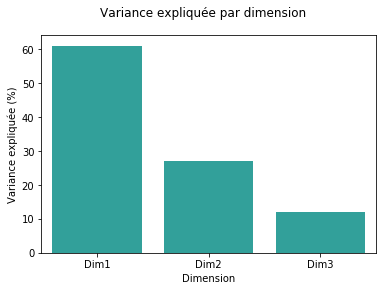

In [72]:
g_eig = seaborn.barplot(x = "Dimension", 
                y = "% variance expliquée",
                palette = ["lightseagreen"],
                data = eig)
g_eig.set(ylabel = "Variance expliquée (%)")
g_eig.figure.suptitle("Variance expliquée par dimension")

On remarque que deux dimensions permettent d'expliquer 88% de la variance

In [73]:
df_pca = pca.transform(df[df.columns[:3]])

Transformation en DataFrame pandas

In [74]:
df_pca_df = pandas.DataFrame({
    "Dim1" : df_pca[:,0], 
    "Dim2" : df_pca[:,1], 
    "Arrondissement" : df.Arrondissement
})

df_pca_df.head()

,Dim1,Dim2,Arrondissement
0,-212.014878,368.911570,1
1,-238.241631,409.991134,2
2,-144.609371,248.867489,3
3,-598.181751,1028.774699,4
4,-2082.561549,3585.672543,5


Text(0.5, 0.98, 'Premier plan factoriel')

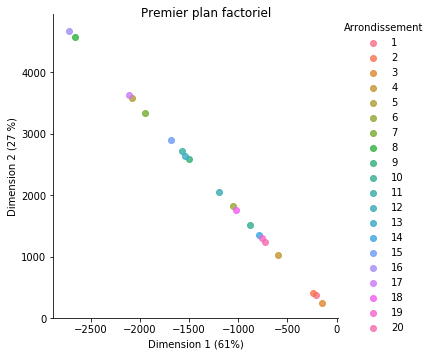

In [75]:
g_pca = seaborn.lmplot("Dim1", "Dim2", hue = "Arrondissement", data = df_pca_df, fit_reg = False)
g_pca.set(xlabel = "Dimension 1 (61%)", ylabel = "Dimension 2 (27 %)")
g_pca.fig.suptitle("Premier plan factoriel")

Passons maintenant à de la classification non-supervisée:

In [76]:
db = DBSCAN(eps = .8, min_samples = 3)
db.fit(scale(df[df.columns[:3]]))

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=None, p=None)

In [77]:
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1,
        0, -1,  0], dtype=int64)

In [78]:
eff = numpy.unique(db.labels_, return_counts = True)
pandas.DataFrame({
    "Classe" : eff[0],
    "Effectif" : eff[1]
})

,Classe,Effectif
0,-1,16
1,0,4


On distingue donc 2 classes.

In [79]:
df_pca_db = df_pca_df.assign(Labels = db.labels_)

Text(0.5, 0.98, 'Premier plan factoriel')

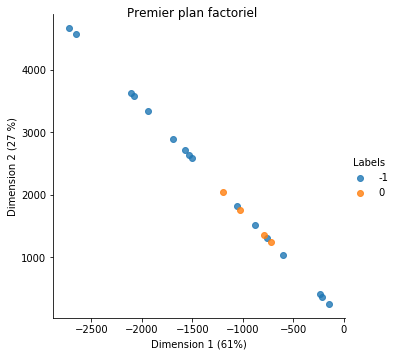

In [80]:
g_pca = seaborn.lmplot("Dim1", "Dim2", hue = "Labels", data = df_pca_db, fit_reg = False)
g_pca.set(xlabel = "Dimension 1 (61%)", ylabel = "Dimension 2 (27 %)")
g_pca.fig.suptitle("Premier plan factoriel")

Evolution du montant total des transactions au cours de l'année.

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


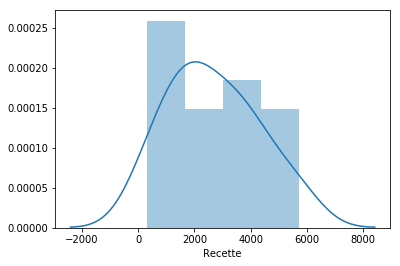

In [81]:
seaborn.distplot(df["Recette"])